# Semi-Supervised Ensemble Model for Water Quality Prediction in Mexico

**Authors:** Raquel Cossío-Ramírez, Hortencia A. Ramírez-Vázquez, Amanda M. Valdez-Calderón


This study’s objective is to create a semi-supervised ensemble model capable of predicting water quality by municipality based on environmental factors, such as population, inundability and industrial activity.

### Setup

Library imports, below are the necessary libraries for data processing, machine learning models, and evaluation metrics.

In [97]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score


In order to predict water quality for municipalities that were not covered by measuring stations, we opt to build a dataset with features that could be indirectly related to water quality. We included features per municipality such as [population](), [altitude](), [area](), [precipitation](), [flood-ability threshold](), [number of water treatment facilities](), [number of wastewater discharge points](), and [number of people working in industries](https://www.inegi.org.mx/app/descarga/ficha.html?tit=2781025&ag=0&f=csv). In this notebook [AllData.csv](https://github.com/raqcoss/ML-water/blob/main/AllData.csv) is the integration of the datasets metioned above.

In [98]:
# Load dataset 
df = pd.read_csv("AllData.csv")
df.set_index("CVEGEO", inplace=True)
df = df.drop(labels=["NOM_ENT","NOM_MUN"], axis = 1)

# Display data
df

,POB_TOTAL,ALTITUD,AREA,UMBRAL12H,PORCENTA_1,agua_AR,agua_FC,agua_PT,avg_impact,avg_agricultura,avg_construccion,avg_manufactura,semaforo
CVEGEO,,,,,,,,,,,,,
1001,948990,1918.046196,116635.92480,57.80700,4.829056,91,226,24,0.900702,21,24.193751,44.979780,Rojo
1002,51536,2030.520325,54337.42660,60.05970,4.274541,0,54,9,0.904023,0,4.500000,2.083333,Verde
1003,58250,1827.143813,92335.78323,60.71769,1.158972,7,43,4,0.787156,3,2.333333,2.835498,Rojo
1004,17000,1967.656566,12838.35445,52.22142,3.153082,10,13,3,0.912407,0,0.000000,1.000000,Rojo
1005,129929,1936.513072,49989.50916,58.46688,3.357602,34,42,16,0.798126,3,23.113636,80.622222,Rojo
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32054,19446,2167.903226,37142.59866,58.41954,5.038430,11,31,3,0.794049,0,0.000000,2.000000,Rojo
32055,31558,1962.535211,215650.56020,61.17057,3.174213,4,10,2,0.726474,46,0.000000,3.076923,Rojo
32056,149607,2263.314961,43682.10105,60.79104,3.129201,5,22,2,0.785869,0,13.555556,9.888060,Rojo


The dataset consists of 2,469 rows and 13 columns, representing various geographical and environmental factors related to water quality assessment.
- **CVEGEO**: Unique geographical identifier for each municipality. 
- **POB_TOTAL**: Total population for each municipality.
- **ALTITUD**: Altitude of each municipality (in meters).
- **AREA**: Total area of each municipality (in square units).
- **UMBRAL12H**: 
- **PORCENTA_1**: 
- **agua_AR**
- **agua_FC**
- **agua_PT**
- **avg_impact**: Average human impact factor.
- **avg_agricultura**, **avg_construccion**, **avg_manufactura**: Average levels of agricultural, construction, and manufacturing activities in the region.
- **semaforo**: Water quality indicator (Rojo = High risk, Amarillo = Moderate risk, Verde = Low risk, NaN = Missing data).

### Data Preprocessing and Normalization

In [99]:
# Scaling data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.drop(columns=["semaforo"]))
                          
X_scaled_df = pd.DataFrame(X_scaled, index=df.index, columns=df.drop(columns=["semaforo"]).columns)
X_scaled_df['semaforo'] = df['semaforo']

## Labeled/Unlabeled Data Separation
X_labeled = X_scaled_df[X_scaled_df["semaforo"].notna()]

y = X_labeled['semaforo'] # target labels

X_labeled.drop(labels = "semaforo", axis = 1, inplace=True)

# Unlabeled samples 
X_unlabeled = X_scaled_df[X_scaled_df["semaforo"].isna()]
X_unlabeled.drop(labels = "semaforo", axis = 1, inplace=True)

# Encoding 'semaforo' column into numerical labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

y_encoded = pd.DataFrame(y_encoded, index=X_labeled.index, columns=['semaforo_encoded'])
y_encoded = y_encoded.astype(int)

# Dataset with encondig values
y_df = pd.DataFrame(y_encoded, index=y.index, columns=['semaforo_encoded'])
y_df["semaforo_encoded"] = y_df["semaforo_encoded"].replace(3, -1)

/tmp/ipykernel_16748/600009329.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_labeled.drop(labels = "semaforo", axis = 1, inplace=True)
/tmp/ipykernel_16748/600009329.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_unlabeled.drop(labels = "semaforo", axis = 1, inplace=True)


### Train-Test Split

Split the labeled dataset into training and testing sets
- 20% of the data is reserved for testing 
- 80% of the data is used for training

In [100]:
x_train, x_test, y_train, y_test = train_test_split(X_labeled, y_df, test_size=0.2, random_state=42, stratify=y_df)

print(f"Train set: x_train = {x_train.shape} y_train = {y_train.shape}")

# Display mapping of categorical labels 
print("\nMapping of categorical labels to numeric values")
for index, label in enumerate(le.classes_):
    print(f"{label} → {index}")

Train set: x_train = (836, 12) y_train = (836, 1)

Mapping of categorical labels to numeric values
Amarillo → 0
Rojo → 1
Verde → 2


### Semi-Supervised Learning (SSL)

In this study, a SSL approach was employed to make use of both labeled and unlabeled data. 

It followed a self-training paradigm, in which an initial classifier trained on labeled data was iteratively refined using high-confidence predictions on unlabeled examples as pseudo-labels. Self-training was used along with an ensemble of three classification algorithms: **XGBoost**, **CatBoost** and **Random Forest**. Proposed SSL model architecture is presented in Figure 1.

<div style="text-align: center;">
    <img src="images/architecture.png" width="650">
    <p style="font-size:14px; color:gray;">Figure 1: Proposed SSL Model Architecture</p>
</div>

Selection strategy (Figure 2) for this model is very simple, where prediction probabilities are averaged for each class. If the maximum average surpasses the 0.9 threshold, the label of the said class is assigned to the municipality. 

<div style="text-align: center;">
    <img src="images/selection_strategy.png" width="500" style="background-color: white; padding: 10px;">
    <p style="font-size:14px; color:gray;">Figure 2: Selection Strategy</p>
</div>


In [101]:
# Supervised Learning Models
models = [CatBoostClassifier(iterations=500, class_weights={1: 0.31, 0: 0.42, 2: .27}, verbose=0),
        XGBClassifier(max_depth=5, reg_alpha=1),
        RandomForestClassifier(max_samples=0.5, class_weight={1: 0.31, 0: 0.42, 2: .27})
]

### Training SSL Ensamble Model

In [102]:
# Confidence threshold
threshold = 0.7  

# maximum training iterations
max_iter = 50


for iteration in range(max_iter):

    print(f"\nIteration {iteration + 1}")
    
    print(x_train.shape, y_train['semaforo_encoded'].unique())

    # Train each model
    for model in models:
        model.fit(x_train, y_train)
    
    # Get predicted probabilities
    probas = [model.predict_proba(X_unlabeled) for model in models]
  

    for i, model in enumerate(models):
        model_preds = model.predict(X_unlabeled)
        unique, counts = np.unique(model_preds, return_counts=True)
        print(f"Model {i} predicted class distribution: {dict(zip(unique, counts))}")

    # Average probabilities    
    avg_probas = np.mean(probas, axis=0)

    # Get confidence and predicted class
    max_probs = np.max(avg_probas, axis=1)
    preds = np.argmax(avg_probas, axis=1)
    
    # Get boolean mask of confident predictions
    confident_mask = pd.Series(max_probs >= threshold, index=X_unlabeled.index)

    if confident_mask.sum() == 0:
        print("No more confident pseudo-labels found.")
        break

    # Select high-confidence 
    new_X = X_unlabeled.loc[confident_mask]
    new_y = preds[confident_mask]

    #Display distribution of newly added pseudo-labels
    unique, counts = np.unique(new_y, return_counts=True)
    dist = dict(zip(unique, counts))
    print(f"Class distribution of added pseudo-labels: {dist}")

    column_name = 'semaforo_encoded'

    # Ensure both are DataFrames with the same column name
    if isinstance(y_train, pd.Series):
        y_train = y_train.to_frame(name=column_name)


    new_y_df = pd.DataFrame(new_y, index=new_X.index, columns=[column_name])
    y_train = pd.concat([y_train, new_y_df], axis=0)

    # Update labeled on dataset
    x_train = pd.concat([x_train, new_X], axis=0)

    # Remove pseudo-labeled data from unlabeled set
    X_unlabeled = X_unlabeled.drop(index=new_X.index)
    
    print(f"Added {confident_mask.sum()} new pseudo-labeled points.")



Iteration 1
(836, 12) [1 0 2]


/home/horte/.local/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Model 0 predicted class distribution: {0: 624, 1: 410, 2: 389}
Model 1 predicted class distribution: {0: 505, 1: 450, 2: 468}
Model 2 predicted class distribution: {0: 606, 1: 510, 2: 307}
Class distribution of added pseudo-labels: {2: 52}
Added 52 new pseudo-labeled points.

Iteration 2
(888, 12) [1 0 2]


/home/horte/.local/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Model 0 predicted class distribution: {0: 519, 1: 420, 2: 432}
Model 1 predicted class distribution: {0: 448, 1: 411, 2: 512}
Model 2 predicted class distribution: {0: 383, 1: 467, 2: 521}
Class distribution of added pseudo-labels: {2: 149}
Added 149 new pseudo-labeled points.

Iteration 3
(1037, 12) [1 0 2]


/home/horte/.local/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Model 0 predicted class distribution: {0: 451, 1: 344, 2: 427}
Model 1 predicted class distribution: {0: 374, 1: 365, 2: 483}
Model 2 predicted class distribution: {0: 298, 1: 328, 2: 596}
Class distribution of added pseudo-labels: {2: 161}
Added 161 new pseudo-labeled points.

Iteration 4
(1198, 12) [1 0 2]


/home/horte/.local/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Model 0 predicted class distribution: {0: 352, 1: 299, 2: 410}
Model 1 predicted class distribution: {0: 313, 1: 309, 2: 439}
Model 2 predicted class distribution: {0: 220, 1: 282, 2: 559}
Class distribution of added pseudo-labels: {2: 162}
Added 162 new pseudo-labeled points.

Iteration 5
(1360, 12) [1 0 2]


/home/horte/.local/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Model 0 predicted class distribution: {0: 309, 1: 230, 2: 360}
Model 1 predicted class distribution: {0: 271, 1: 234, 2: 394}
Model 2 predicted class distribution: {0: 196, 1: 245, 2: 458}
Class distribution of added pseudo-labels: {2: 186}
Added 186 new pseudo-labeled points.

Iteration 6
(1546, 12) [1 0 2]


/home/horte/.local/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Model 0 predicted class distribution: {0: 256, 1: 213, 2: 244}
Model 1 predicted class distribution: {0: 247, 1: 204, 2: 262}
Model 2 predicted class distribution: {0: 180, 1: 191, 2: 342}
Class distribution of added pseudo-labels: {2: 94}
Added 94 new pseudo-labeled points.

Iteration 7
(1640, 12) [1 0 2]


/home/horte/.local/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Model 0 predicted class distribution: {0: 241, 1: 185, 2: 193}
Model 1 predicted class distribution: {0: 226, 1: 195, 2: 198}
Model 2 predicted class distribution: {0: 171, 1: 188, 2: 260}
Class distribution of added pseudo-labels: {2: 48}
Added 48 new pseudo-labeled points.

Iteration 8
(1688, 12) [1 0 2]


/home/horte/.local/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Model 0 predicted class distribution: {0: 239, 1: 176, 2: 156}
Model 1 predicted class distribution: {0: 225, 1: 184, 2: 162}
Model 2 predicted class distribution: {0: 163, 1: 178, 2: 230}
Class distribution of added pseudo-labels: {2: 29}
Added 29 new pseudo-labeled points.

Iteration 9
(1717, 12) [1 0 2]


/home/horte/.local/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Model 0 predicted class distribution: {0: 231, 1: 173, 2: 138}
Model 1 predicted class distribution: {0: 204, 1: 183, 2: 155}
Model 2 predicted class distribution: {0: 158, 1: 168, 2: 216}
Class distribution of added pseudo-labels: {2: 21}
Added 21 new pseudo-labeled points.

Iteration 10
(1738, 12) [1 0 2]


/home/horte/.local/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Model 0 predicted class distribution: {0: 226, 1: 172, 2: 123}
Model 1 predicted class distribution: {0: 207, 1: 168, 2: 146}
Model 2 predicted class distribution: {0: 153, 1: 154, 2: 214}
Class distribution of added pseudo-labels: {2: 16}
Added 16 new pseudo-labeled points.

Iteration 11
(1754, 12) [1 0 2]


/home/horte/.local/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Model 0 predicted class distribution: {0: 227, 1: 166, 2: 112}
Model 1 predicted class distribution: {0: 199, 1: 171, 2: 135}
Model 2 predicted class distribution: {0: 154, 1: 156, 2: 195}
Class distribution of added pseudo-labels: {2: 11}
Added 11 new pseudo-labeled points.

Iteration 12
(1765, 12) [1 0 2]


/home/horte/.local/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Model 0 predicted class distribution: {0: 199, 1: 165, 2: 130}
Model 1 predicted class distribution: {0: 191, 1: 177, 2: 126}
Model 2 predicted class distribution: {0: 141, 1: 156, 2: 197}
Class distribution of added pseudo-labels: {2: 12}
Added 12 new pseudo-labeled points.

Iteration 13
(1777, 12) [1 0 2]


/home/horte/.local/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Model 0 predicted class distribution: {0: 212, 1: 162, 2: 108}
Model 1 predicted class distribution: {0: 192, 1: 167, 2: 123}
Model 2 predicted class distribution: {0: 165, 1: 152, 2: 165}
Class distribution of added pseudo-labels: {2: 4}
Added 4 new pseudo-labeled points.

Iteration 14
(1781, 12) [1 0 2]


/home/horte/.local/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Model 0 predicted class distribution: {0: 213, 1: 158, 2: 107}
Model 1 predicted class distribution: {0: 201, 1: 169, 2: 108}
Model 2 predicted class distribution: {0: 141, 1: 154, 2: 183}
Class distribution of added pseudo-labels: {2: 4}
Added 4 new pseudo-labeled points.

Iteration 15
(1785, 12) [1 0 2]


/home/horte/.local/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Model 0 predicted class distribution: {0: 208, 1: 172, 2: 94}
Model 1 predicted class distribution: {0: 194, 1: 169, 2: 111}
Model 2 predicted class distribution: {0: 145, 1: 156, 2: 173}
Class distribution of added pseudo-labels: {2: 6}
Added 6 new pseudo-labeled points.

Iteration 16
(1791, 12) [1 0 2]


/home/horte/.local/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Model 0 predicted class distribution: {0: 209, 1: 162, 2: 97}
Model 1 predicted class distribution: {0: 191, 1: 164, 2: 113}
Model 2 predicted class distribution: {0: 150, 1: 156, 2: 162}
Class distribution of added pseudo-labels: {2: 6}
Added 6 new pseudo-labeled points.

Iteration 17
(1797, 12) [1 0 2]


/home/horte/.local/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Model 0 predicted class distribution: {0: 199, 1: 162, 2: 101}
Model 1 predicted class distribution: {0: 187, 1: 164, 2: 111}
Model 2 predicted class distribution: {0: 157, 1: 150, 2: 155}
Class distribution of added pseudo-labels: {2: 2}
Added 2 new pseudo-labeled points.

Iteration 18
(1799, 12) [1 0 2]


/home/horte/.local/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Model 0 predicted class distribution: {0: 193, 1: 165, 2: 102}
Model 1 predicted class distribution: {0: 188, 1: 161, 2: 111}
Model 2 predicted class distribution: {0: 148, 1: 147, 2: 165}
Class distribution of added pseudo-labels: {2: 2}
Added 2 new pseudo-labeled points.

Iteration 19
(1801, 12) [1 0 2]


/home/horte/.local/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Model 0 predicted class distribution: {0: 196, 1: 163, 2: 99}
Model 1 predicted class distribution: {0: 195, 1: 158, 2: 105}
Model 2 predicted class distribution: {0: 146, 1: 159, 2: 153}
Class distribution of added pseudo-labels: {2: 4}
Added 4 new pseudo-labeled points.

Iteration 20
(1805, 12) [1 0 2]


/home/horte/.local/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Model 0 predicted class distribution: {0: 195, 1: 157, 2: 102}
Model 1 predicted class distribution: {0: 185, 1: 164, 2: 105}
Model 2 predicted class distribution: {0: 144, 1: 146, 2: 164}
Class distribution of added pseudo-labels: {2: 3}
Added 3 new pseudo-labeled points.

Iteration 21
(1808, 12) [1 0 2]


/home/horte/.local/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Model 0 predicted class distribution: {0: 205, 1: 153, 2: 93}
Model 1 predicted class distribution: {0: 187, 1: 151, 2: 113}
Model 2 predicted class distribution: {0: 158, 1: 145, 2: 148}
Class distribution of added pseudo-labels: {2: 3}
Added 3 new pseudo-labeled points.

Iteration 22
(1811, 12) [1 0 2]


/home/horte/.local/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Model 0 predicted class distribution: {0: 191, 1: 153, 2: 104}
Model 1 predicted class distribution: {0: 185, 1: 166, 2: 97}
Model 2 predicted class distribution: {0: 147, 1: 147, 2: 154}
Class distribution of added pseudo-labels: {2: 1}
Added 1 new pseudo-labeled points.

Iteration 23
(1812, 12) [1 0 2]


/home/horte/.local/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Model 0 predicted class distribution: {0: 191, 1: 158, 2: 98}
Model 1 predicted class distribution: {0: 188, 1: 158, 2: 101}
Model 2 predicted class distribution: {0: 151, 1: 142, 2: 154}
Class distribution of added pseudo-labels: {2: 1}
Added 1 new pseudo-labeled points.

Iteration 24
(1813, 12) [1 0 2]


/home/horte/.local/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Model 0 predicted class distribution: {0: 193, 1: 160, 2: 93}
Model 1 predicted class distribution: {0: 180, 1: 162, 2: 104}
Model 2 predicted class distribution: {0: 153, 1: 143, 2: 150}
No more confident pseudo-labels found.


### Testing SSL Ensamble Model

In [103]:
# Probabilities for each model
test_probas = [model.predict_proba(x_test) for model in models]

# Average probabilities across models
avg_test_probas = np.mean(test_probas, axis=0)

# Highest probability for each sample (Confidence level)
max_probs = np.max(avg_test_probas, axis=1)
ensemble_preds = np.argmax(avg_test_probas, axis=1)

# Ensable model's performance
print("Ensemble Accuracy:", accuracy_score(y_test, ensemble_preds))
print("\n",classification_report(y_test, ensemble_preds))

Ensemble Accuracy: 0.42857142857142855

               precision    recall  f1-score   support

           0       0.55      0.46      0.50        89
           1       0.51      0.40      0.45        65
           2       0.27      0.41      0.33        56

    accuracy                           0.43       210
   macro avg       0.44      0.42      0.43       210
weighted avg       0.46      0.43      0.44       210



#### Confusion Matrix

Confusion Matrix:
 [[41 15 33]
 [11 26 28]
 [23 10 23]]


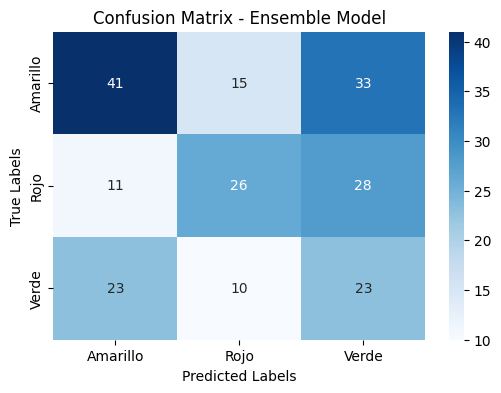

In [ ]:
conf_matrix = confusion_matrix(y_test, ensemble_preds)

print("Confusion Matrix:\n", conf_matrix)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - Semi-supervised Ensemble Model")
plt.show()

In [105]:
#Trained data

y_train

,semaforo_encoded
CVEGEO,
20039,1
11030,0
4006,1
31050,0
13069,1
...,...
12002,2
19028,2
20007,2


### Comparison with Random Forest

A most commonly used approach is Random Forest, that combined the output of multiple decision trees to reach a prediction. It utilizes the bagging method and feature randomness, only selecting a subset of all possible features, to create an uncorrelated forest of decision trees.

/home/horte/.local/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 0.5666666666666667

Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.72      0.67        93
           1       0.54      0.64      0.59        67
           2       0.41      0.18      0.25        50

    accuracy                           0.57       210
   macro avg       0.52      0.51      0.50       210
weighted avg       0.54      0.57      0.54       210



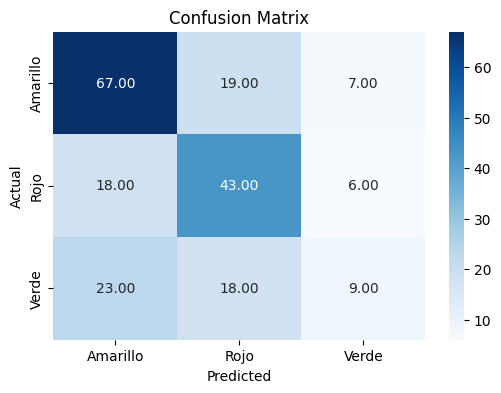

In [ ]:

# Define features and target
X = X_labeled 
y = y

# Enconding 'semaforo' label
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_encoded = pd.DataFrame(y_encoded, index=X_labeled.index, columns=['semaforo_encoded'])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Training 
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)

# Testing
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.show()

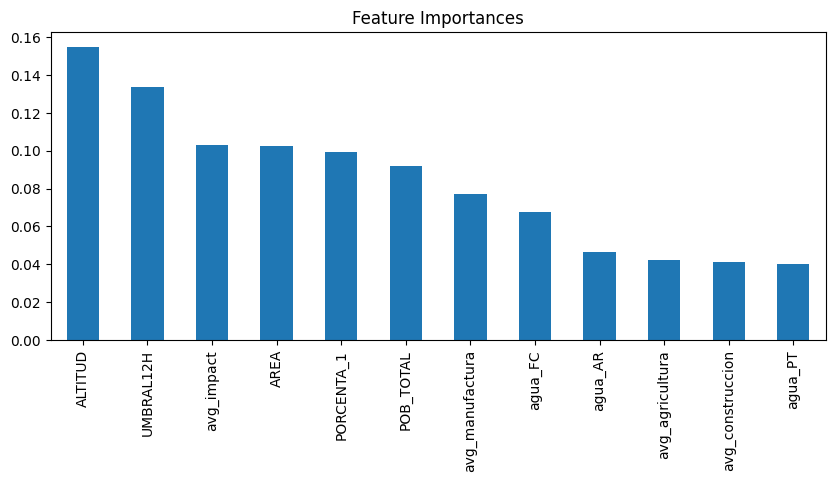

In [85]:
feature_importances = pd.Series(clf.feature_importances_, index=X.columns)
feature_importances.sort_values(ascending=False).plot(kind="bar", figsize=(10, 4), title="Feature Importances")
plt.show()